# In this notebook, we are going to implement MLP model to analysis the data
## https://en.wikipedia.org/wiki/Multilayer_perceptron


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [3]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age   sex     localization  \
8311  HAM_0006608  ISIC_0025491   nv      histo  60.0  male             back   
4408  HAM_0001074  ISIC_0030764   nv  follow_up  50.0  male  lower extremity   
589   HAM_0006211  ISIC_0025519  bkl      histo  50.0  male             neck   
6345  HAM_0003009  ISIC_0025569   nv  follow_up  40.0  male             back   
8550  HAM_0001911  ISIC_0029197   nv      histo  55.0  male             back   

      label  
8311      5  
4408      5  
589       2  
6345      5  
8550      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [89]:
import math
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(0.4*total_data/float(value))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])

total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.2807341649502186
2   1.2933925618221422
1   2.0533252507705986
0   2.50558834532851
6   3.3397214586245028
3   3.5506163878625134


In [5]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [6]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

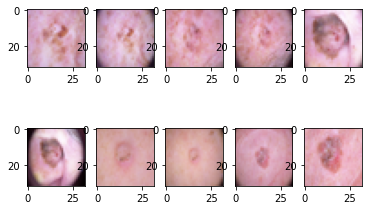

In [7]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [90]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.3,random_state=random.randint(1,99))

In [91]:
#setup MLP model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.25))

#hidden layer 2
model.add(Dense(units=512,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.25))

#hidden layer 3
model.add(Dense(units=256,input_dim=12288,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.25))

#output Dense layer 7 classes + softmax activation
model.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 7)                

In [92]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 256
epochs = 30

train_history = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,class_weight=class_weight)

Epoch 1/30
11/11 - 1s - loss: 2.9638 - acc: 0.5159 - val_loss: 1.3440 - val_acc: 0.6562
Epoch 2/30
11/11 - 0s - loss: 1.8862 - acc: 0.6526 - val_loss: 1.3319 - val_acc: 0.6562
Epoch 3/30
11/11 - 0s - loss: 1.7903 - acc: 0.6733 - val_loss: 1.2473 - val_acc: 0.6562
Epoch 4/30
11/11 - 0s - loss: 1.7390 - acc: 0.6731 - val_loss: 1.1724 - val_acc: 0.6562
Epoch 5/30
11/11 - 0s - loss: 1.6562 - acc: 0.6719 - val_loss: 1.1616 - val_acc: 0.6562
Epoch 6/30
11/11 - 0s - loss: 1.6096 - acc: 0.6692 - val_loss: 1.1242 - val_acc: 0.6562
Epoch 7/30
11/11 - 0s - loss: 1.5837 - acc: 0.6696 - val_loss: 1.1555 - val_acc: 0.6562
Epoch 8/30
11/11 - 0s - loss: 1.5749 - acc: 0.6708 - val_loss: 1.0506 - val_acc: 0.6562
Epoch 9/30
11/11 - 0s - loss: 1.5650 - acc: 0.6676 - val_loss: 1.0617 - val_acc: 0.6562
Epoch 10/30
11/11 - 0s - loss: 1.5538 - acc: 0.6724 - val_loss: 1.1111 - val_acc: 0.6562
Epoch 11/30
11/11 - 0s - loss: 1.5232 - acc: 0.6699 - val_loss: 1.0282 - val_acc: 0.6562
Epoch 12/30
11/11 - 0s - loss:

In [74]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

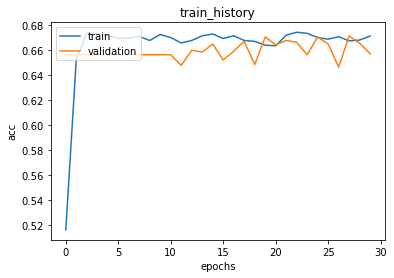

In [93]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

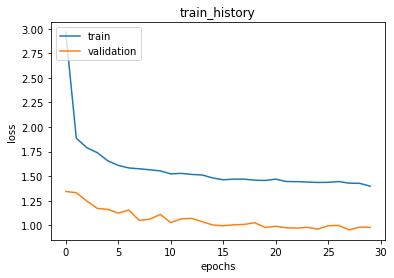

In [94]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [95]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

94/94 [==============================] - 0s 2ms/step - loss: 0.9615 - acc: 0.6725
Test accuracy: 0.6725457310676575


In [96]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))

[5 5 5 ... 5 1 5]
predict   0   1   2   4     5
label                        
0        34  20   1   0    58
1        25  70   4   0    77
2        26  70  11  14   210
3         4   6   1   0    10
4         9  10  10  27   256
5        13  58   6  49  1879
6         5   3   0   2    37
